<a href="https://colab.research.google.com/github/Samarth-991/ML-Projects/blob/master/13_AirBnb_DataExpolarion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AirrPnb_DataMonitor

Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019.

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data
# ! unzip /content/new-york-city-airbnb-open-data.zip
# ! rm -rf /content/new-york-city-airbnb-open-data.zip

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [4]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# AB_NYC_2019.csv has 48895 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/AB_NYC_2019.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'AB_NYC_2019.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 16 columns


In [5]:
df1.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


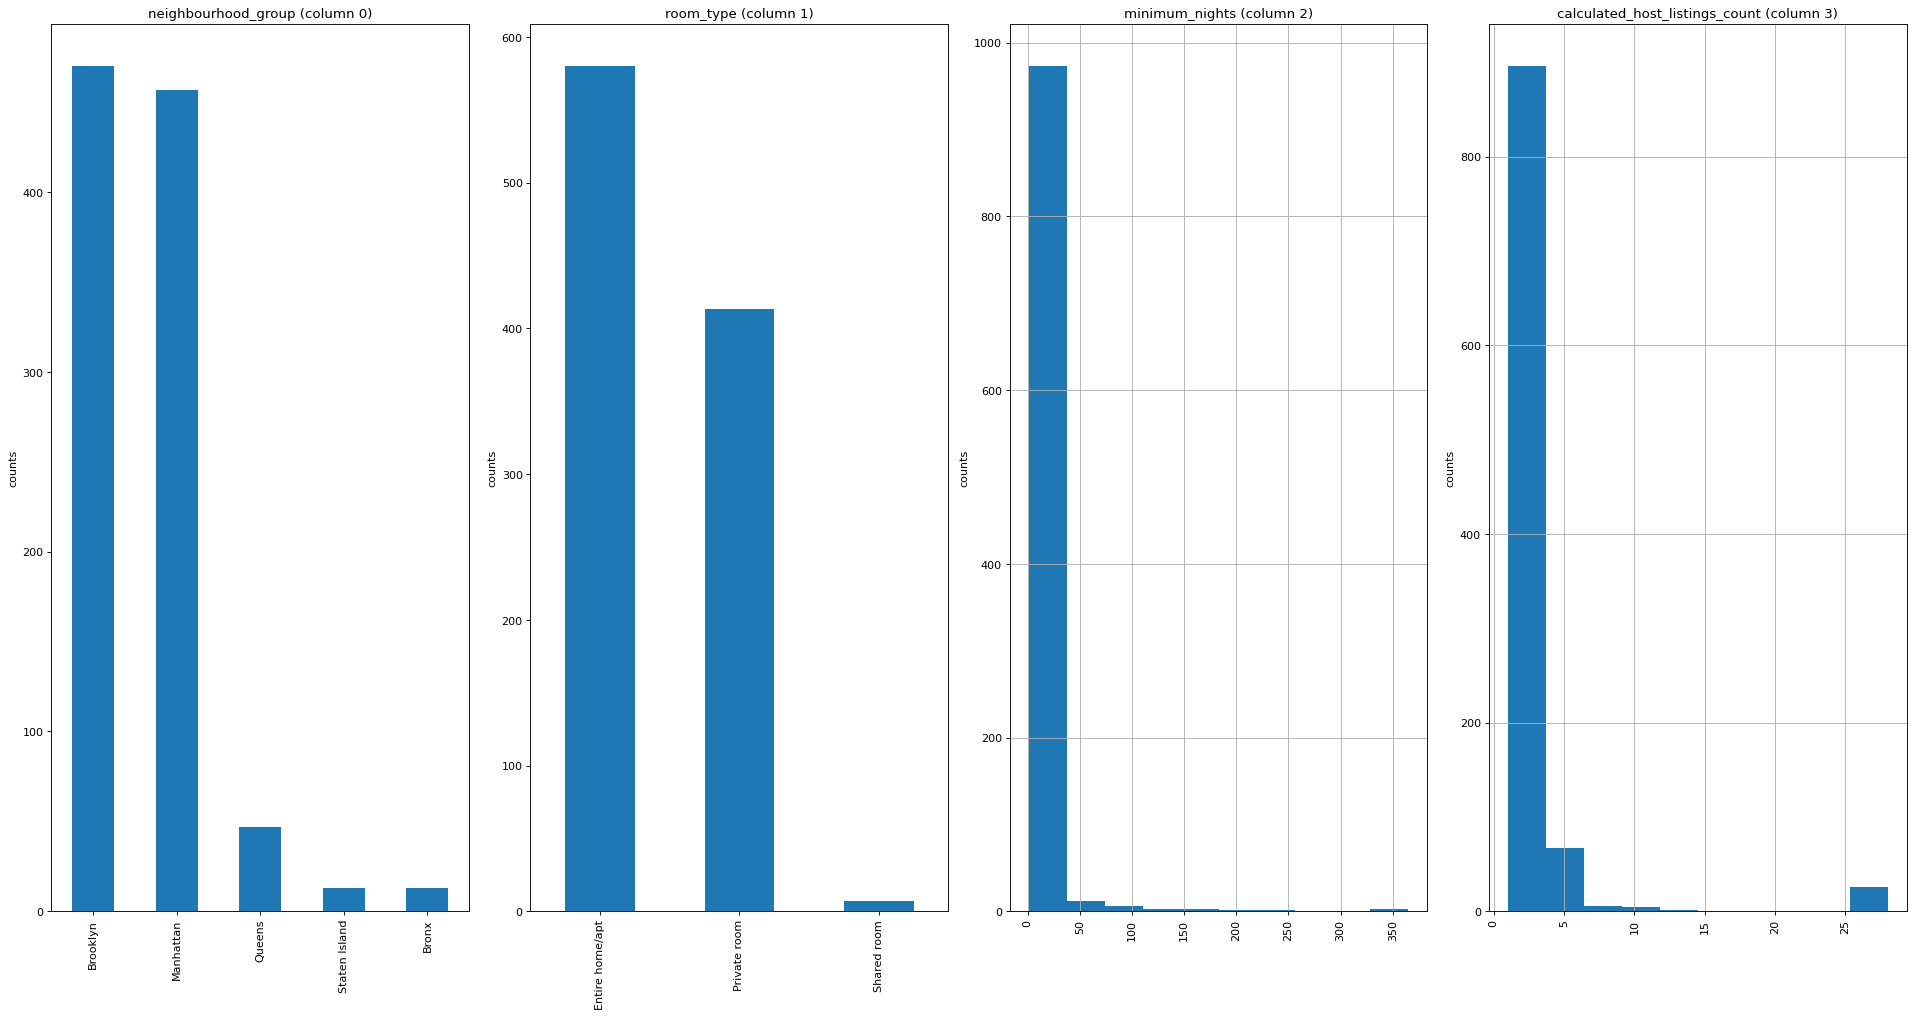

In [6]:
plotPerColumnDistribution(df1, 10, 5)

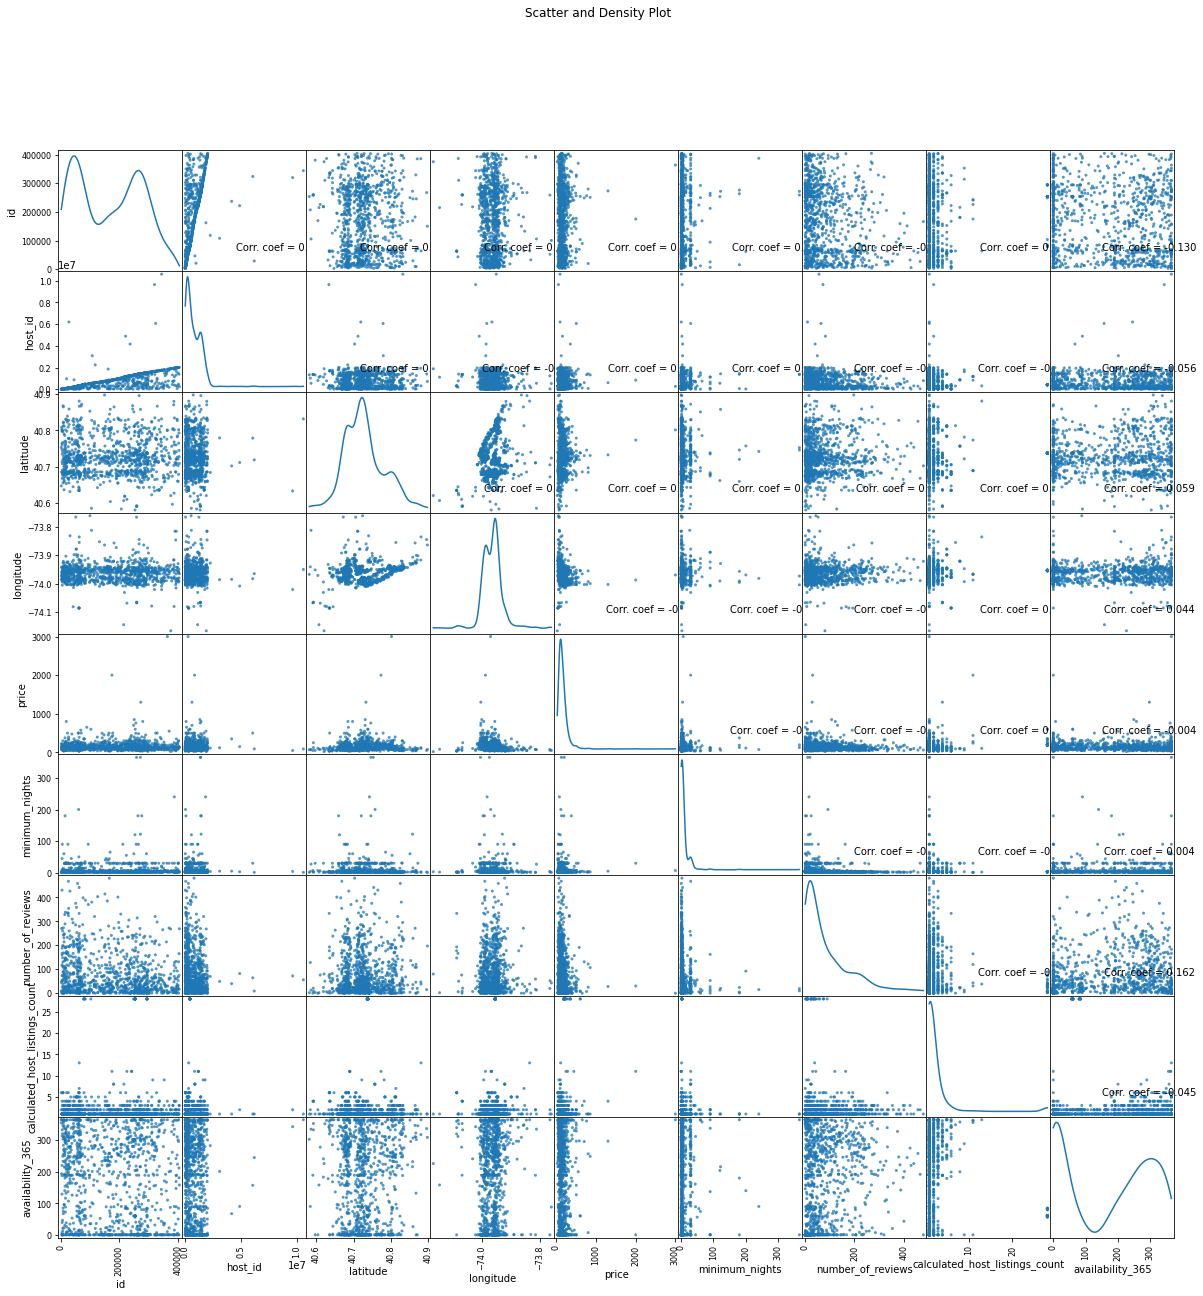

In [7]:
plotScatterMatrix(df1, 20, 10)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1000 non-null   int64  
 1   name                            1000 non-null   object 
 2   host_id                         1000 non-null   int64  
 3   host_name                       999 non-null    object 
 4   neighbourhood_group             1000 non-null   object 
 5   neighbourhood                   1000 non-null   object 
 6   latitude                        1000 non-null   float64
 7   longitude                       1000 non-null   float64
 8   room_type                       1000 non-null   object 
 9   price                           1000 non-null   int64  
 10  minimum_nights                  1000 non-null   int64  
 11  number_of_reviews               1000 non-null   int64  
 12  last_review                     959

In [9]:
# Convert id and host_id dtypes to object (str)
df1[['id', 'host_id']] = df1[['id', 'host_id']].astype(str)
# Drop columns name, host_name, and last_review
df1 = df1.drop(['name', 'host_name', 'last_review'], axis=1, inplace=False)

# Impute missing value with 0 in reviews_per_month
df1['reviews_per_month'] = df1['reviews_per_month'].fillna(0)
# count the sum of null columsns after pre-processing
df1.isnull().sum()
print("airpnb Data shape",df1.shape)

airpnb Data shape (1000, 13)


In [10]:
df1.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,40.728265,-73.963382,158.282000,9.137000,79.865000,0.893060,2.375000,169.895000
std,0.051538,0.033430,152.031708,24.284521,88.511169,0.966637,4.403381,132.998009
min,40.581470,-74.165340,20.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.687815,-73.984525,85.000000,2.000000,15.000000,0.200000,1.000000,19.500000
50%,40.722120,-73.960920,128.000000,3.000000,46.000000,0.555000,1.000000,189.000000
75%,40.757452,-73.948388,195.000000,6.000000,117.000000,1.282500,2.000000,293.000000
max,40.897470,-73.761330,3000.000000,365.000000,480.000000,7.140000,28.000000,365.000000


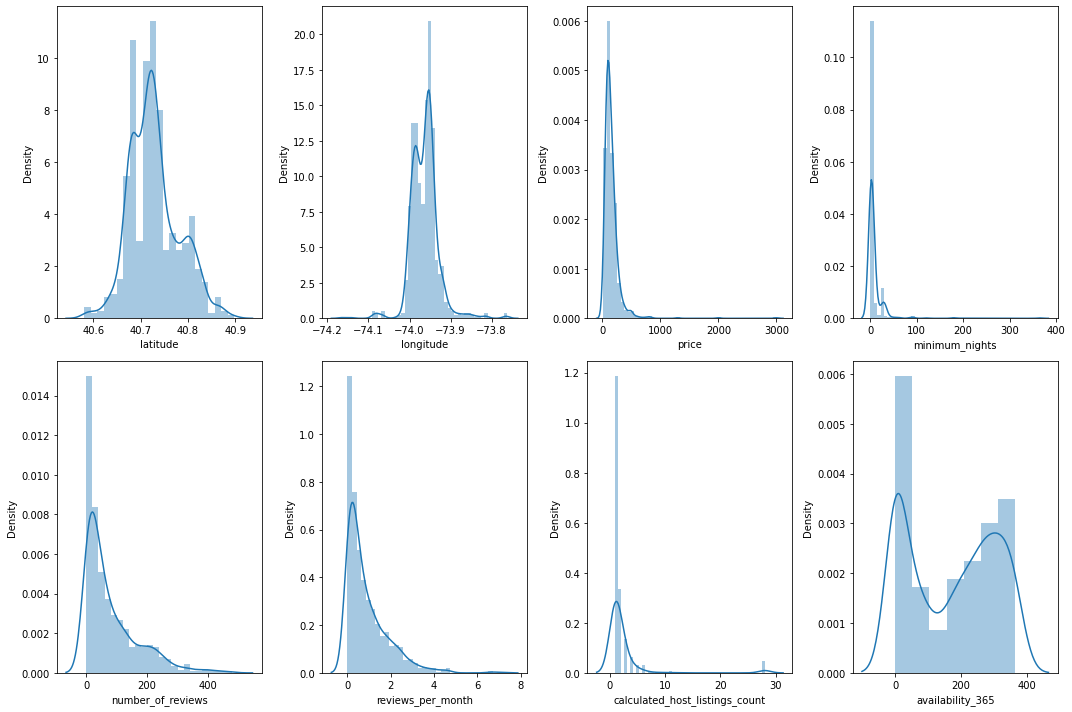

In [11]:
airbnb_dataset_num = df1[['latitude', 'longitude', 'price', 'minimum_nights',
                                     'number_of_reviews', 'reviews_per_month',
                                     'calculated_host_listings_count', 'availability_365']].copy()

airbnb_columns_num = airbnb_dataset_num.columns.values
plt.figure(figsize=(15, 10))
for i in range(0,len(airbnb_columns_num)):
    plt.subplot(2, 4, i+1)
    sns.distplot(airbnb_dataset_num[airbnb_columns_num[i]])
    plt.tight_layout()

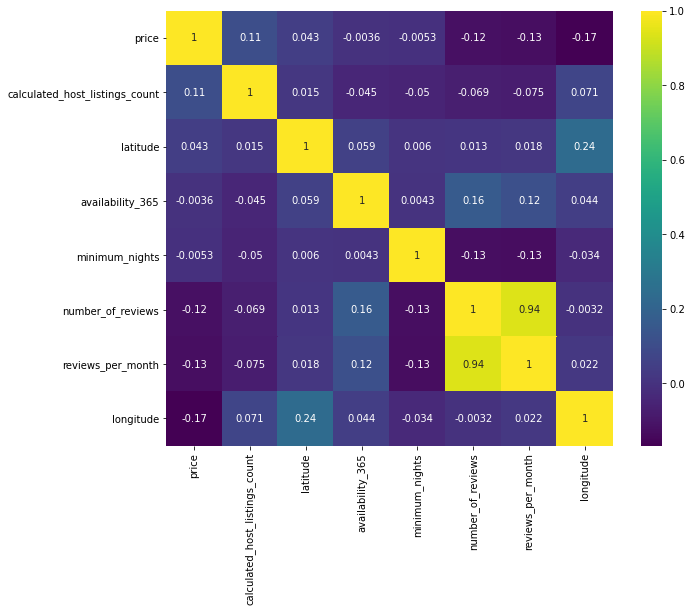

In [12]:
k = 8
cols = airbnb_dataset_num.corr().nlargest(k, 'price')['price'].index
cm = airbnb_dataset_num[cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap = 'viridis')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

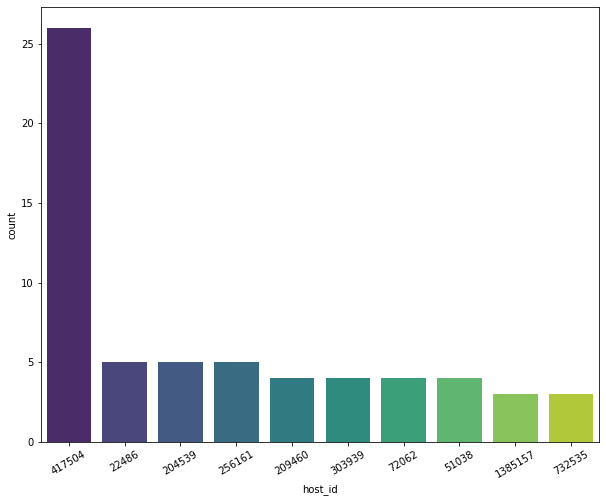

In [13]:
top_host = pd.DataFrame(df1['host_id'].value_counts()).reset_index().head(10)
top_host.rename(columns={'index':'host_id', 'host_id':'count'}, inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(data=top_host, x=top_host['host_id'], y=top_host['count'], palette='viridis')
plt.xticks(rotation=30)

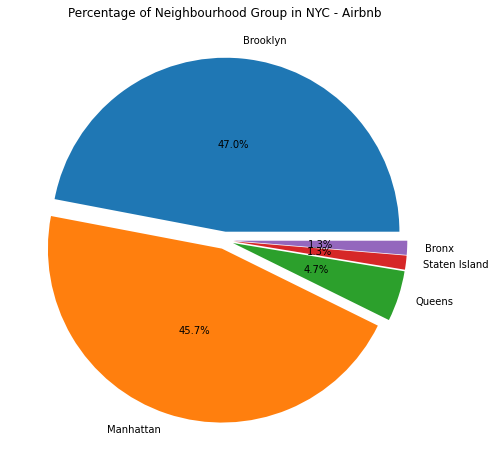

In [14]:
# Count the number of neighbourhood group in NYC Airbnb
ngroup_count = df1['neighbourhood_group'].value_counts()

pie, ax = plt.subplots(figsize=(10,8))
labels = ngroup_count.keys()
plt.pie(x=ngroup_count, autopct='%.1f%%', explode=[0.05]*5, labels=labels, pctdistance=0.5)
plt.title('Percentage of Neighbourhood Group in NYC - Airbnb')
plt.show()

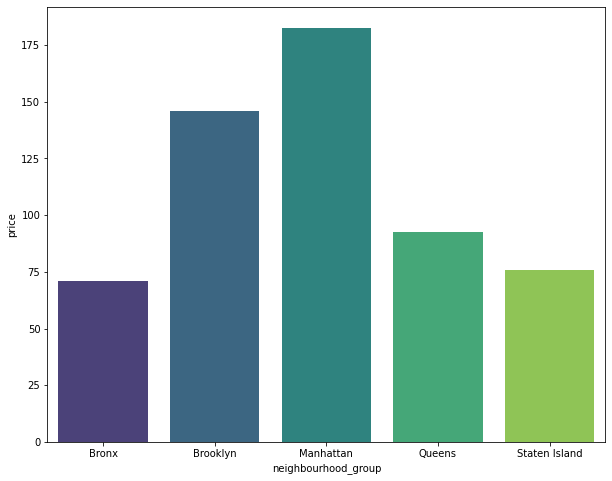

In [15]:
# Airbnb dataset groupby neighbourhood_group with price-mean
ngroup = df1.groupby('neighbourhood_group', as_index=False)[['price']].mean()

plt.figure(figsize=(10,8))
sns.barplot(data=ngroup, x=ngroup['neighbourhood_group'], y=ngroup['price'], palette='viridis')

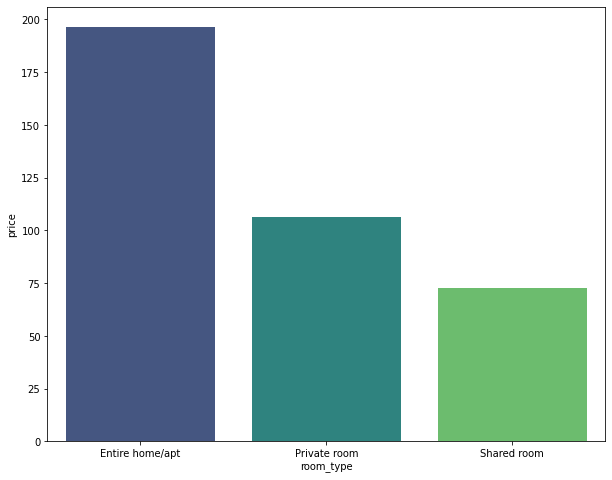

In [16]:
# Airbnb dataset groupby room_type with price-mean
rtype = df1.groupby('room_type', as_index=False)[['price']].mean()

plt.figure(figsize=(10,8))
sns.barplot(data=rtype, x=rtype['room_type'], y=rtype['price'], palette='viridis')

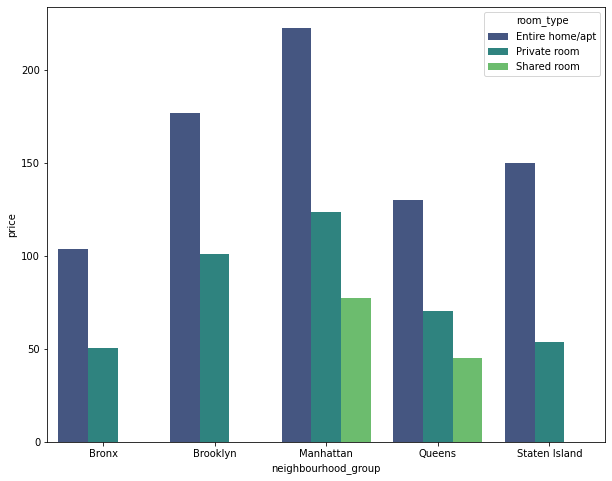

In [17]:
# Stacked bar
# Airbnb dataset groupby neighbourhood_group x room_type with price-mean
n_r_group = pd.DataFrame(df1.groupby(['neighbourhood_group', 'room_type'],
                                                as_index=False)[['price']].mean())

plt.figure(figsize=(10,8))
sns.barplot(data=n_r_group, x=n_r_group['neighbourhood_group'], y=n_r_group['price'],
            hue=n_r_group['room_type'], palette='viridis')

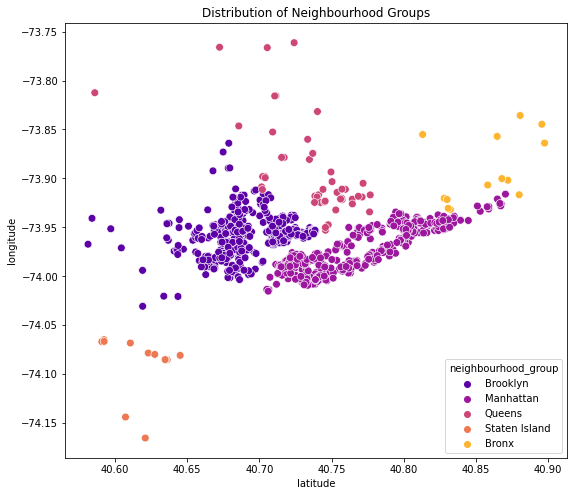

In [18]:
#Analyzing the accomodation availability
plt.figure(figsize=(9,8))
plt.title('Distribution of Neighbourhood Groups')
plt.rc('axes',titlesize=14)
sns.scatterplot(data=df1,x='latitude',y='longitude',
               hue='neighbourhood_group',
               palette='plasma',
               s=60)

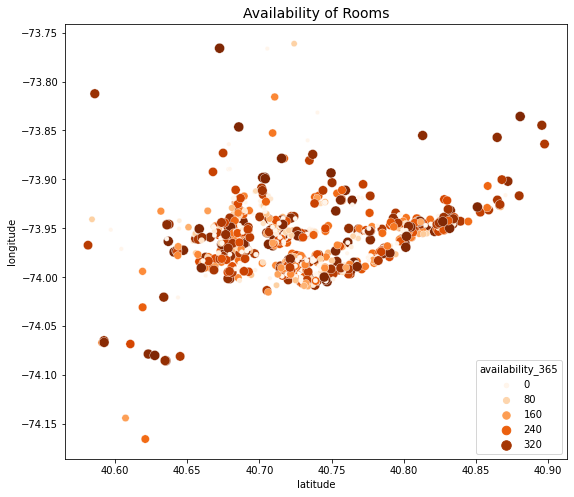

In [19]:
#  rooms have the most availablity
plt.figure(figsize=(9,8))
plt.title('Availability of Rooms')
plt.rc('axes',titlesize=14)
sns.scatterplot(data=df1,x='latitude',y='longitude',
               size='availability_365',
               hue='availability_365',
               sizes=(20,100),
               palette='Oranges',
               s=70)

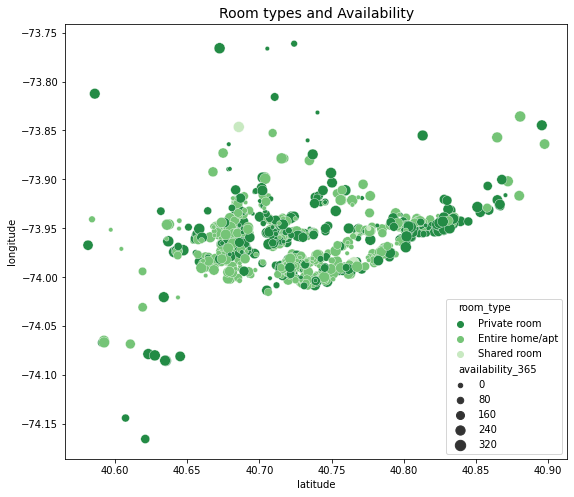

In [20]:
#Countplot for analyzing which neighbouhood has the most Accomodations
plt.figure(figsize=(9,8))
plt.title('Room types and Availability')
plt.rc('axes',titlesize=14)
sns.scatterplot(data=df1,x='latitude',y='longitude',
               size='availability_365',
               hue='room_type',
               sizes=(20,120),
               palette='Greens_r',
               s=70)

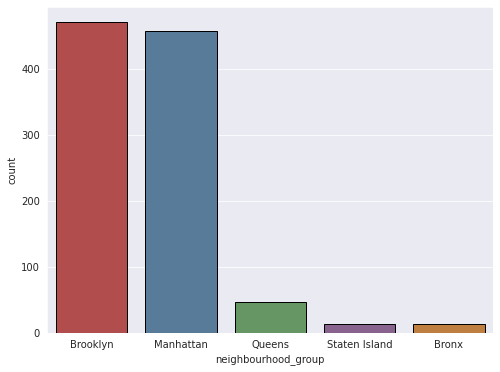

In [21]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
sns.countplot(data=df1,x='neighbourhood_group',
             palette='Set1',
             saturation=0.5,
             linewidth=1.0,
             edgecolor='black')

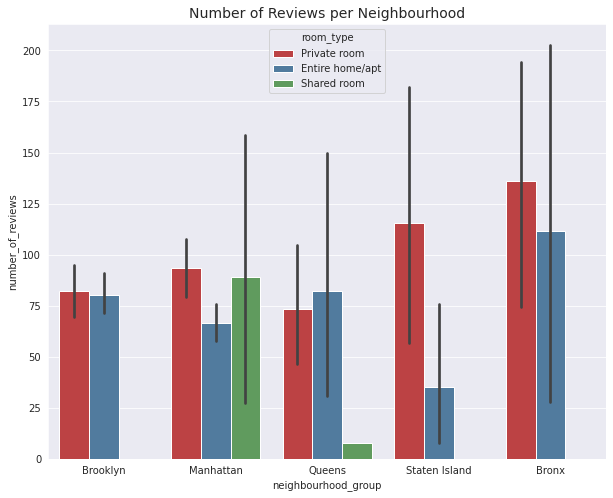

In [22]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
plt.title('Number of Reviews per Neighbourhood')
plt.rc('axes',titlesize=14)
sns.barplot(data=df1,x='neighbourhood_group',
            y='number_of_reviews',
            hue='room_type',
            palette='Set1',
            saturation=0.6
            )

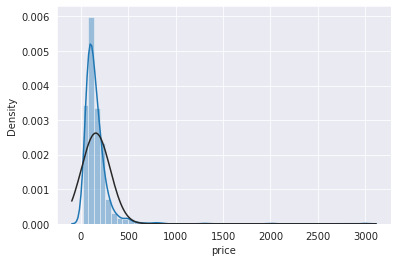

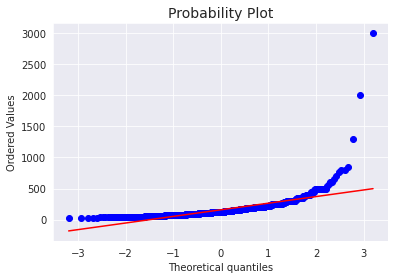

In [23]:
from scipy.stats import norm
# Testing Normality
#histogram and normal probability plot
sns.distplot(df1['price'],fit=norm);
fig = plt.figure()
res = stats.probplot(df1['price'], plot=plt)

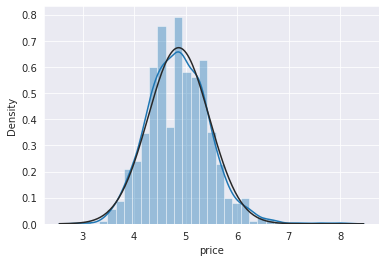

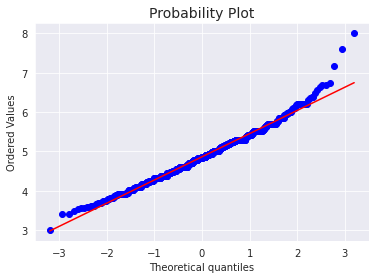

In [24]:
#applying log transformation
df1['price'] = np.log(df1['price'])
#transformed histogram and normal probability plot
sns.distplot(df1['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['price'], plot=plt)

In [26]:
df1 = df1.drop(['id', 'host_id'], axis=1, inplace=False)
df1.shape

(1000, 11)

In [27]:
df1 = pd.get_dummies(df1)
df1

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arrochar,neighbourhood_Astoria,neighbourhood_Bay Ridge,neighbourhood_Bedford-Stuyvesant,neighbourhood_Bensonhurst,neighbourhood_Boerum Hill,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Brooklyn Heights,neighbourhood_Bushwick,neighbourhood_Carroll Gardens,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_Clason Point,neighbourhood_Clifton,neighbourhood_Clinton Hill,neighbourhood_Cobble Hill,neighbourhood_Columbia St,neighbourhood_Concourse,neighbourhood_Concourse Village,neighbourhood_Crown Heights,neighbourhood_Cypress Hills,neighbourhood_DUMBO,neighbourhood_Ditmars Steinway,neighbourhood_East Flatbush,neighbourhood_East Harlem,...,neighbourhood_Morningside Heights,neighbourhood_Murray Hill,neighbourhood_NoHo,neighbourhood_Nolita,neighbourhood_Ozone Park,neighbourhood_Park Slope,neighbourhood_Prospect Heights,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Queens Village,neighbourhood_Rego Park,neighbourhood_Ridgewood,neighbourhood_Rockaway Beach,neighbourhood_Roosevelt Island,neighbourhood_Sheepshead Bay,neighbourhood_Shore Acres,neighbourhood_SoHo,neighbourhood_South Slope,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Tompkinsville,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Williamsburg,neighbourhood_Windsor Terrace,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.003946,1,9,0.21,6,365,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,5.416100,1,45,0.38,2,355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,5.010635,3,0,0.00,1,365,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,4.488636,1,270,4.64,1,194,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,4.382027,10,9,0.10,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,40.80192,-73.95827,4.828314,1,0,0.00,1,365,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
996,40.79314,-73.94853,4.828314,3,74,0.84,3,212,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
997,40.74530,-73.99056,4.976734,3,165,1.88,2,181,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
998,40.72812,-73.97966,4.990433,2,16,0.18,1,0,0,0,1,0,0,0,0,0,0,0,0,

In [28]:
y=df1.price
X=df1.drop('price',axis=1)
print("Database shape ",X.shape)
print("Target variable shape",y.shape)

Database shape  (1000, 112)
Target variable shape (1000,)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge,ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
print("Train data",X_train.shape)
print("Test data",X_test.shape)
print("Ytrain",y_train.shape)
print("y_test",y_test.shape)

Train data (700, 112)
Test data (300, 112)
Ytrain (700,)
y_test (300,)


In [31]:
#Tune parameters
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [40]:
# parameters = {'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
#              'gamma':[0, 0.025, 0.05, 0.075, 0.1],
#              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#             'max_depth': [3, 5, 10, 15, 20],
#             'min_child_weight': [0, 2, 5, 10, 20],
#             'n_estimators': [500, 1000, 2000, 3000, 5000],
#             'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
#             'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
#             'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
#            }


# model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05, 
#                            learning_rate=0.05, max_depth=3, 
#                            min_child_weight=5, n_estimators=2000,
#                            reg_alpha=0.5, reg_lambda=0.8,
#                            subsample=0.5, random_state =7)

# gsearch = GridSearchCV(model_xgb,
#                        param_grid=parameters, scoring='neg_mean_squared_error', cv=2)
# gsearch.fit(X_train, y_train)

# gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

In [63]:
#Best model
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5,gamma=0.05, 
                            learning_rate=0.05,max_depth=3, 
                            min_child_weight=3,n_estimators=4000,
                            reg_alpha=0.5,reg_lambda=0.8,
                            subsample=0.5,random_state =7)
#Fit model
model_xgb.fit(X_train, y_train)

[13:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.05,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=4000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=7,
             reg_alpha=0.5, reg_lambda=0.8, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

In [64]:
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = model_xgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print (np.sqrt(mean_squared_error(y_test,xgb_pred)))

0.13535391529288562
0.4650387857168441
